# Прогноз стоимости аренды M&Y (Электрификации 26)

### Подключение библиотек и скриптов

In [35]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

%matplotlib inline

In [36]:
def show_dst(train_df, column):
    plt.figure(figsize = (16, 8))

    train_df[column].hist(bins=18)
    plt.ylabel('Count')
    plt.xlabel(column)

    plt.title('Target distribution')
    plt.show()
    return None

### Загрузка данных

In [37]:
TRAIN_DATASET_PATH = 'Lubertsy.csv'

In [38]:
df = pd.read_csv(TRAIN_DATASET_PATH, delimiter=';', decimal=',', index_col='ID')

**Описание датасета**

* **Id** - идентификационный номер объекта
* **Type** - тип объекта
* **Square** - площадь
* **Time from metro auto** - время на машине до метро
* **KM from MKAD** - расстояние до МКАДА
* **Floor** - номер этажа объекта
* **Total Floors** - количество этажей объекта
* **Roofs** - высота потолков
* **Parking** - наличие паркинга
* **Entrance** - вход
* **Price** - общая цена аренды
* **Price/m** - цена за метр

# Предобработка

In [39]:
df.head(10)

,Type,Square,Time from metro auto,Metro,KM from MKAD,Building,Floor,Roofs,Parking,Entrance,Price,Link,Price/m,Total Floors
ID,,,,,,,,,,,,,,
1,Storehouse,28.00,NaN,NaN,6.0,Free,1,2.70,Yes,NaN,10100.0,https://www .cian .ru/rent/commercial/226196743,360.71,1
2,Storehouse,28.00,4.0,Kotelniki,6.0,NaN,1,NaN,Yes,NaN,12012.0,https://www .cian .ru/rent/commercial/226322956,429.00,1
3,Office,19.75,4.0,Kotelniki,5.0,Administrative,3,NaN,NaN,NaN,22713.0,https://www .cian .ru/rent/commercial/234449801,1150.03,4
4,Free,54.00,6.0,Nekrasovka,NaN,Residential,1,3.25,NaN,Street,75000.0,https://www .cian .ru/rent/commercial/236932064,1388.89,17
5,Free,175.80,5.0,Lukhmanovskaya,NaN,Residential,1,NaN,NaN,Street,316440.0,https://www .cian .ru/rent/commercial/233699528,1800.00,25
6,StreetRetail,80.00,4.0,Lukhmanovskaya,NaN,Administrative,1,2.80,NaN,Street,353334.0,https://www .cian .ru/rent/commercial/230961390,4416.68,1
7,Office,58.00,NaN,NaN,5.0,Business,4,NaN,Yes,NaN,63800.0,https://www .cian .ru/rent/commercial/227973692,1100.00,5
8,Free,131.00,3.0,Nekrasovka,NaN,Residential,1,NaN,NaN,Street,140000.0,https://www .cian .ru/rent/commercial/234463561,1068.70,17
9,StreetRetail,1261.37,3.0,Lermontovskyprospect,5.0,Business,1,5.00,NaN,Street,1702850.0,https://www .cian .ru/rent/commercial/228009503,1350.00,5


In [40]:
df = df.drop('Link', axis = 'columns')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 13 columns):
Type                    205 non-null object
Square                  205 non-null float64
Time from metro auto    148 non-null float64
Metro                   145 non-null object
KM from MKAD            164 non-null float64
Building                144 non-null object
Floor                   205 non-null int64
Roofs                   146 non-null float64
Parking                 38 non-null object
Entrance                124 non-null object
Price                   200 non-null float64
Price/m                 200 non-null float64
Total Floors            205 non-null int64
dtypes: float64(6), int64(2), object(5)
memory usage: 22.4+ KB


### Заполнение пропусков

In [42]:
values = {'Parking': 'No', 'Entrance': 'Street', 'Roofs': 3, 'Time from metro auto': 5, 'KM from MKAD': 5, 'Metro': 'Other', 'Building': 'Other'}
df.fillna(value=values, inplace=True)

In [43]:
df_num_features = df.select_dtypes(include=('float64','int64'))
df_num_features.dtypes
df_num_features.describe()

,Square,Time from metro auto,KM from MKAD,Floor,Roofs,Price,Price/m,Total Floors
count,205.000000,205.000000,205.000000,205.000000,205.000000,2.000000e+02,200.000000,205.000000
mean,180.946220,6.185366,5.639024,1.409756,3.662293,1.219671e+05,1061.867500,6.858537
std,337.574886,3.952510,1.453171,1.533260,1.696266,2.191086e+05,1037.686796,7.877399
min,5.000000,2.000000,1.000000,-1.000000,0.020000,6.800000e+03,177.780000,1.000000
25%,40.000000,4.000000,5.000000,1.000000,3.000000,3.225000e+04,420.000000,2.000000
50%,82.000000,5.000000,5.000000,1.000000,3.000000,6.700450e+04,800.000000,3.000000
75%,175.800000,7.000000,7.000000,2.000000,4.000000,1.118250e+05,1254.750000,6.000000
max,3000.000000,20.000000,9.000000,15.000000,13.000000,1.702850e+06,6805.050000,25.000000


In [44]:
df = pd.get_dummies(df)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 33 columns):
Square                        205 non-null float64
Time from metro auto          205 non-null float64
KM from MKAD                  205 non-null float64
Floor                         205 non-null int64
Roofs                         205 non-null float64
Price                         200 non-null float64
Price/m                       200 non-null float64
Total Floors                  205 non-null int64
Type_Free                     205 non-null uint8
Type_Mall                     205 non-null uint8
Type_Manufacture              205 non-null uint8
Type_Office                   205 non-null uint8
Type_Storehouse               205 non-null uint8
Type_StreetRetail             205 non-null uint8
Metro_Kotelniki               205 non-null uint8
Metro_Lermontovskyprospect    205 non-null uint8
Metro_Lukhmanovskaya          205 non-null uint8
Metro_Nekrasovka              205 non-null uint8
M

### Отделение прогнозируемого объекта от остальных объявлений

In [46]:
Miles = df.loc[201:].copy()

In [47]:
df = df.drop(201, 0)
df = df.drop(202, 0)
df = df.drop(203, 0)

In [48]:
Miles = Miles.drop('Price', axis = 'columns')
Miles = Miles.drop('Price/m', axis = 'columns')

### Удаление выбросов

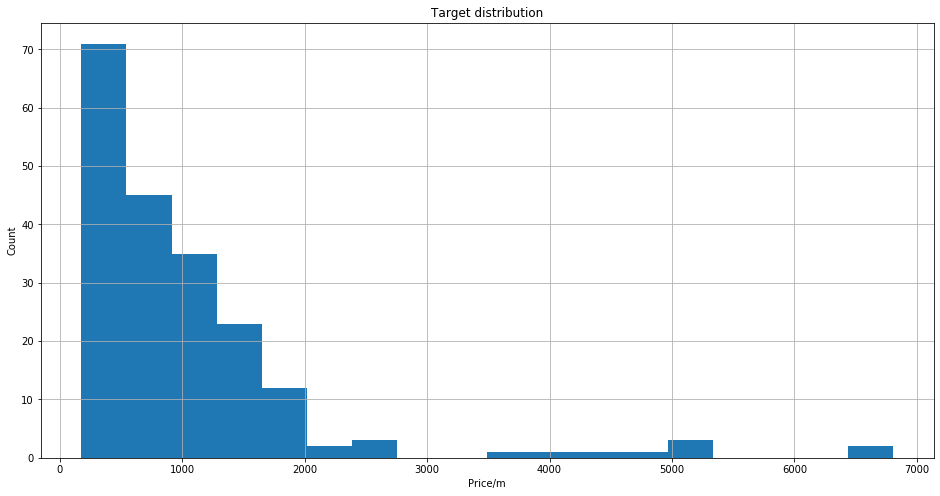

In [49]:
show_dst(df, 'Price/m')

In [50]:
df = df[(df['Price/m'] < 3000)]

### Обучение модели

In [51]:
df = df.drop('Price', axis = 'columns')

In [52]:
features = df.drop('Price/m', axis = 'columns').columns.tolist()
target = ['Price/m']

In [53]:
X_train, X_valid,y_train, y_valid = train_test_split(df[features], df[target], test_size = 0.2, random_state = 20)

In [54]:
def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2
    
def two_score(y_true,y_pred):
    score = R2(y_true,y_pred)
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=True)


parameters = {
    'n_estimators': [200, 250, 350],
    'max_depth': np.arange(10, 18),
}

model = RandomForestRegressor()
clf = GridSearchCV(model, parameters, scoring=two_scorer())

In [55]:
clf.fit(X_train, y_train)

R2: 0.072
R2: 0.236
R2: 0.285
R2: 0.124
R2: 0.268
R2: 0.308
R2: 0.105
R2: 0.269
R2: 0.311
R2: 0.130
R2: 0.259
R2: 0.282
R2: 0.116
R2: 0.256
R2: 0.316
R2: 0.127
R2: 0.265
R2: 0.321
R2: 0.128
R2: 0.266
R2: 0.298
R2: 0.115
R2: 0.277
R2: 0.313
R2: 0.116
R2: 0.265
R2: 0.283
R2: 0.118
R2: 0.305
R2: 0.309
R2: 0.123
R2: 0.239
R2: 0.311
R2: 0.080
R2: 0.223
R2: 0.309
R2: 0.129
R2: 0.266
R2: 0.302
R2: 0.101
R2: 0.260
R2: 0.309
R2: 0.089
R2: 0.234
R2: 0.307
R2: 0.095
R2: 0.265
R2: 0.310
R2: 0.100
R2: 0.270
R2: 0.301
R2: 0.122
R2: 0.249
R2: 0.309
R2: 0.074
R2: 0.287
R2: 0.322
R2: 0.132
R2: 0.234
R2: 0.295
R2: 0.095
R2: 0.275
R2: 0.307
R2: 0.138
R2: 0.260
R2: 0.295
R2: 0.112
R2: 0.290
R2: 0.289
R2: 0.090
R2: 0.265
R2: 0.289


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([10, 11

In [56]:
cv_results = pd.DataFrame(clf.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [57]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_max_depth,param_n_estimators,mean_test_score
9,13,200,0.243913
5,11,350,0.237395
7,12,250,0.234543
1,10,250,0.232862
12,14,200,0.231808
21,17,200,0.230713
6,12,200,0.230378
22,17,250,0.230088
4,11,250,0.228943
2,10,350,0.227862


In [58]:
clf.best_params_

{'max_depth': 13, 'n_estimators': 200}

In [59]:
best_model_params = clf.best_params_

In [60]:
best_model = RandomForestRegressor(max_depth=best_model_params['max_depth'], n_estimators=best_model_params['n_estimators'])

In [61]:
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [62]:
y_pred = best_model.predict(X_valid)

r2_score(y_valid, y_pred)

0.4940259299614258

### Тест на всех данных

In [63]:
all_pred = best_model.predict(df[features])

In [64]:
r2_score(all_pred, df[target])

0.6949686222617042

### Тест на вводных

In [65]:
prediction = best_model.predict(Miles)

In [73]:
print('Цена за метр (Электрификации 26 - Склад):', round(prediction[0]) * 12, 'руб.')
print('Цена за метр (Электрификации 26 - Офис):', round(prediction[1]) * 12, 'руб.')
print('Цена за метр (Электрификации 26 - Производство):', round(prediction[2] * 12), 'руб.')
print('Цена за метр (Электрификации 26 - Торговля):', round(prediction[3] * 12), 'руб.')
print('Цена за метр (Электрификации 26 - Свободное):', round(prediction[4] * 12), 'руб.')

Цена за метр (Электрификации 26 - Склад): 4464.0 руб.
Цена за метр (Электрификации 26 - Офис): 5748.0 руб.
Цена за метр (Электрификации 26 - Производство): 5437.0 руб.
Цена за метр (Электрификации 26 - Торговля): 10500.0 руб.
Цена за метр (Электрификации 26 - Свободное): 8860.0 руб.
